# Intro

This notebook will handle everything related to modeling the data to fit into the Kaggle competition. For this, we have a simple workflow. We start by loading the training data and fit several models to it. Afterwards, we apply these trained models to the test data and evaluate their results, choosing the best one and submitting it to Kaggle. 

The criteria for evaluation will be the Area Under the Curve (AUC)

Let's get this started then. We start by handling all the imports necessary.

In [1]:
# First we will handle all the imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve

We can now start loading the actual data that will be used in the models

In [2]:
train_data = pd.read_csv("../data/train.csv", sep=",")
test_data = pd.read_csv("../data/test.csv", sep=",")

# Separate into features and labels
unwanted = ["status", "loan_id", "frequency", "loan_date"]
features = [x for x in list(train_data) if x not in unwanted]
target = "status"

# Order the entries in the dataframe by time,
# so the Time Splitter works properly
train_data.sort_values(by="loan_date", inplace=True)
test_data.sort_values(by="loan_date", inplace=True)

X = train_data[features]
Y = train_data[target]

X, X_test, y, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# Apply SMOTE so the training classes are balanced
# For the moment, SMOTE and the Time Series Split do not work together. It was decided that splitting by time
# lead to better results, but we will try to investigate this further
#smote = SMOTE(random_state=0)
#X, y = smote.fit_resample(X, y)

# Training a Model and finding the best parameters

With the data loaded, we can start trying to find the best model to predict the results. To find the best hyperparameters for each model, we will use Grid Searching, as randomized searches would not yield any better results, and evaluate the results using the AUC metric. As for splitting, we will use the `TimeSeriesSplit`, as it splits the data taking in account timed events.

In [3]:
SPLITTER = TimeSeriesSplit()

def train_model_grid(model, params, cv=SPLITTER):
    grid_search = GridSearchCV(estimator=model,
                               param_grid=params,
                               n_jobs=-1,
                               cv=cv,
                               scoring='roc_auc',
                               verbose=1,
                               refit=True)
    
    grid_search.fit(X, y)
    print(f"Best params for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best Score: {grid_search.best_score_}")
    
    return grid_search.best_estimator_

# Evaluating a model to check for applicability

With the model trained, we can check the results on the testing data and try to find out which one performs the best out of all of them. We will once again use the Area Under the Curve (AUC) as our metric, and we will show a Confusion Matrix to detail exactly what happenned with the data, and decide if it is a good fit or not.

In [4]:
def evaluate(model):
    y_pred = model.predict_proba(X_test)
    
    # Area Under the Curve, the higher the better
    auc = metrics.roc_auc_score(y_test, y_pred[:,-1])
    print(f"AUC Score on Testing Data: {auc}")

    y_pred_normalized = np.argmax(model.predict_proba(X_test), axis=1)

    cm = metrics.confusion_matrix(y_test, y_pred_normalized)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="Blues")

    # labels, title and ticks
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(["Not Accepted", "Accepted"])
    ax.yaxis.set_ticklabels(["Not Accepted", "Accepted"])
    
    # We want the results for the other class, so we use that one in the end
    return y_pred[:,0]

# Exporting the Data

With the model trained, we can now look to apply it to the competition data as well, and (ideally) obtain great results with it as well

In [5]:
def export_results(model, file):
    test = test_data[features]

    confidences = model.predict_proba(test)
    confidences = confidences[:,0]

    confidences = [0 if x < 0.000001 else x for x in confidences]
    confidences = ["{:f}".format(x) for x in confidences]

    submition_data = pd.DataFrame()

    submition_data["Id"] = test_data["loan_id"]
    submition_data["Predicted"] = confidences
    
    submition_data.to_csv(f"../results/{file}.csv", sep=",", index=False)
    
    print(f"Done exporting to: {file}.csv")

# Joining it all together

With this wrapper function, it becomes much easier to evaluate all the models

In [6]:
# The predicted results might be useful if we wish to compare the different models
def apply(model, params):
    best_model = train_model_grid(model, params)
    predicted_results = evaluate(best_model)
    export_results(best_model, best_model.__class__.__name__)
    
    return predicted_results

Fitting 5 folds for each of 1520 candidates, totalling 7600 fits
Best params for DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 5, 'min_samples_split': 9}
Best Score: 0.824987123987124
AUC Score on Testing Data: 0.6563025210084034
Done exporting to: DecisionTreeClassifier.csv


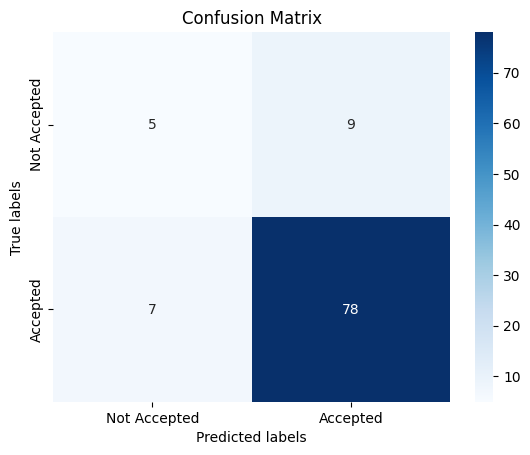

In [7]:
dt_results = apply(DecisionTreeClassifier(), {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 20),
    'min_samples_split': range(2,10),
    'min_samples_leaf': range(1,6)
})

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and

/usr/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best params for RandomForestClassifier: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.8572056832056832
AUC Score on Testing Data: 0.8815126050420168
Done exporting to: RandomForestClassifier.csv


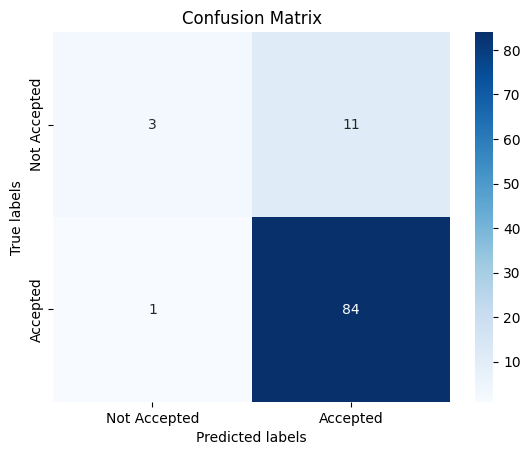

In [8]:
rf_results = apply(RandomForestClassifier(random_state=0),{ 
    'n_estimators': [100, 150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [8,9,10,11,12],
    'criterion' :['gini', 'entropy'],
    'bootstrap': [True],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2,3],
})

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params for SVC: {'C': 10, 'degree': 1, 'kernel': 'poly'}
Best Score: 0.7549692529692529
AUC Score on Testing Data: 0.7638655462184873
Done exporting to: SVC.csv


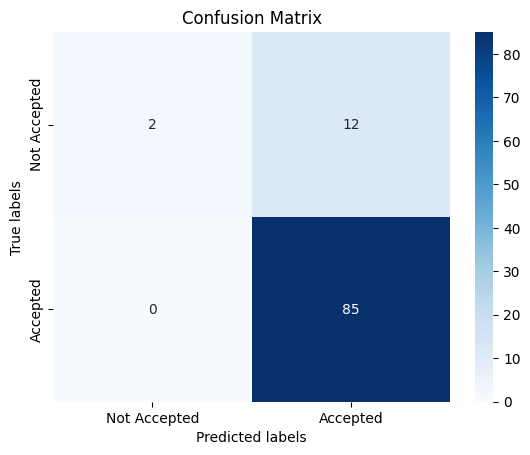

In [9]:
svm_results = apply(SVC(probability=True),
    {'C': [1, 10, 50, 100],
    'kernel': ['poly', 'rbf'],
    'degree': [1, 2]
})

Fitting 5 folds for each of 35 candidates, totalling 175 fits


/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

Best params for MLPClassifier: {'alpha': 0.75, 'hidden_layer_sizes': 100}
Best Score: 0.6946176046176047
AUC Score on Testing Data: 0.5600840336134454
Done exporting to: MLPClassifier.csv


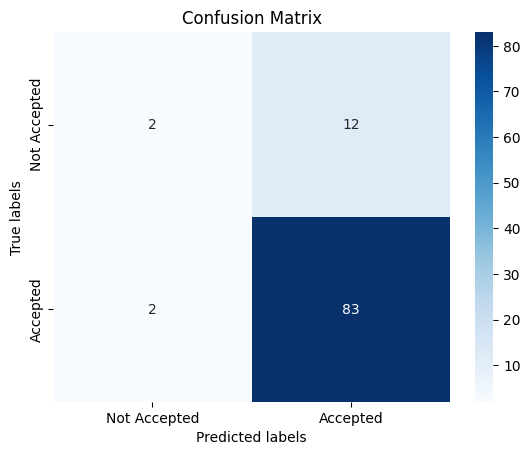

In [10]:
mlb_results = apply(MLPClassifier(),{
    'alpha': [0.1, 0.25, 0.45, 0.5, 0.55, 0.75, 0.85],
    'hidden_layer_sizes': [10, 20, 30, 60, 100]
})

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best params for KNeighborsClassifier: {'n_neighbors': 28, 'weights': 'distance'}
Best Score: 0.6755937395937396
AUC Score on Testing Data: 0.5785714285714286
Done exporting to: KNeighborsClassifier.csv


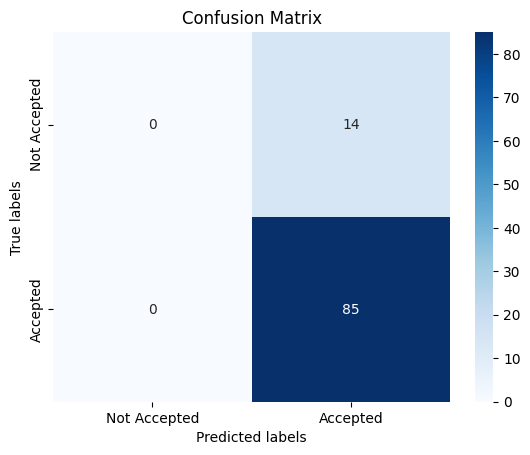

In [11]:
knn_results = apply(KNeighborsClassifier(),{
    "n_neighbors": list(range(1,31)),
    "weights": ['uniform', 'distance'],
})

Fitting 5 folds for each of 1050 candidates, totalling 5250 fits
Best params for GradientBoostingClassifier: {'max_depth': 5, 'max_features': 7, 'min_samples_leaf': 30, 'min_samples_split': 200}
Best Score: 0.5
AUC Score on Testing Data: 0.8058823529411765
Done exporting to: GradientBoostingClassifier.csv


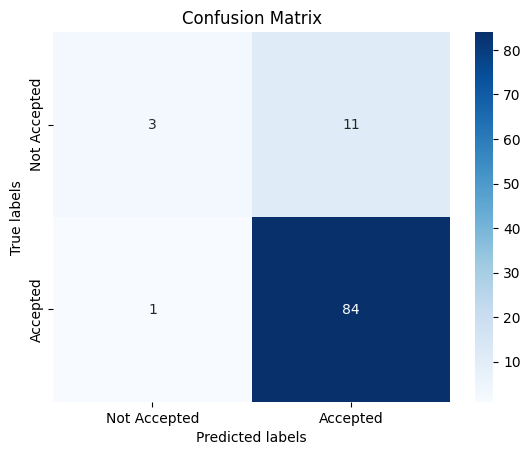

In [12]:
logistic_results = apply(GradientBoostingClassifier(), {
    'max_features': range(7,20,2),
    'min_samples_split':range(1000,2100,200),
    'min_samples_leaf':range(30,71,10),
    'max_depth':range(5,16,2),
    'min_samples_split':range(200,1001,200)
})

# Compare the different curves

With this small step we can compare the different resutls in order to otbain a graphical representation

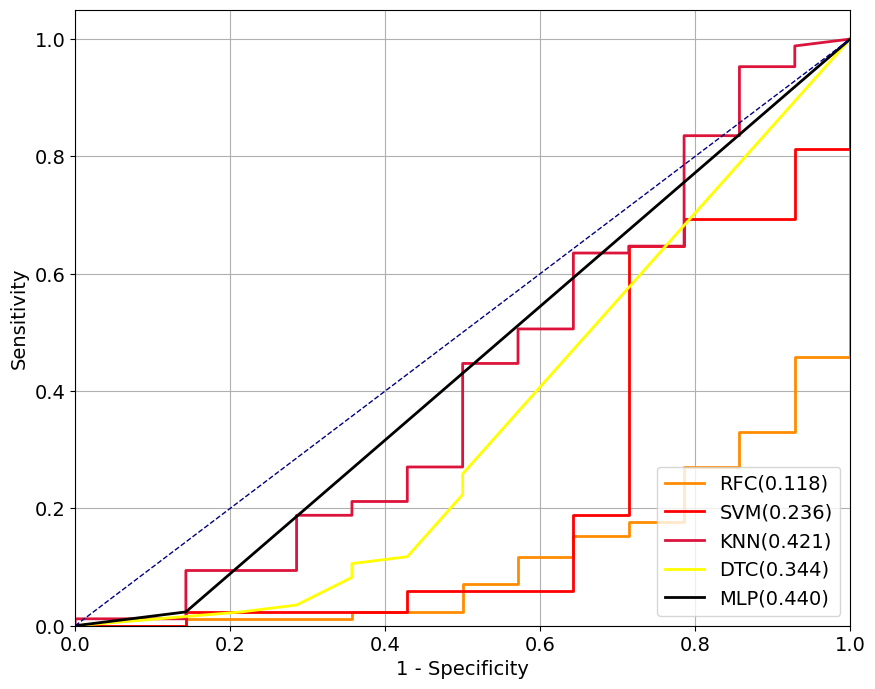

In [13]:
np.random.seed(2019)

def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = metrics.roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = metrics.roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc


plt.figure(figsize=(10, 8))
matplotlib.rcParams.update({'font.size': 14})
plt.grid()

fpr, tpr, roc_auc = roc_curve_and_score(y_test, rf_results)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='RFC({0:.3f})'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, svm_results)
plt.plot(fpr, tpr, color='red', lw=2, label='SVM({0:.3f})'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, knn_results)
plt.plot(fpr, tpr, color='crimson', lw=2, label='KNN({0:.3f})'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, dt_results)
plt.plot(fpr, tpr, color='yellow', lw=2, label='DTC({0:.3f})'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, mlb_results)
plt.plot(fpr, tpr, color='black', lw=2, label='MLP({0:.3f})'.format(roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()